# Visualization tools
These provide graph views of the tax lots where:
* Individual tax lots are nodes, colored red if closed with a capital loss and green if closed with a capital gain.
* Labelled edges indicate where a lot came from a split Lot or wash-loss.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from tax_tracker import CapGainsTracker, Lot

def graph_summary(G: nx.DiGraph) -> None:
    pos = nx.nx_pydot.pydot_layout(G, prog="dot")
    color_map = {'Open': (.0, .0, .0, 0.1), 'Loss': (1.0, .0, .0, 0.4), 'Gain': (.0, 1.0, .0, 0.5)}
    node_colors = [color_map[G.nodes[node]["status"]] for node in G.nodes]
    node_labels = nx.get_node_attributes(G, 'lot_id')
    edge_labels = nx.get_edge_attributes(G, 'label')
    color_map = {'Basis': "purple", 'Split': (.0, .0, 1.0, 0.4)}
    edge_colors = [color_map[G.edges[edge].get("label")] for edge in G.edges]
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=False, node_size=300, node_color=node_colors, font_size=10,
            arrowsize=20, edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.show()

def graph_detail(G: nx.DiGraph, title: str = None) -> None:
    pos = nx.nx_pydot.pydot_layout(G, prog="dot")
    color_map = {'Open': (.0, .0, .0, 0.1), 'Loss': (1.0, .0, .0, 0.4), 'Gain': (.0, 1.0, .0, 0.5)}
    node_colors = [color_map[G.nodes[node]["status"]] for node in G.nodes]
    node_labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')
    color_map = {'Basis': "purple", 'Split': (.0, .0, 1.0, 0.4)}
    edge_colors = [color_map[G.edges[edge].get("label")] for edge in G.edges]
    plt.figure(figsize=(11, 7))
    nx.draw(G, pos, with_labels=False, node_size=5000, node_color=node_colors, font_size=9,
            arrowsize=20, edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    if title is not None:
        plt.title(title)
    plt.show()

# Example 1.1
This reproduces Example 1.1, then uses the graphs to visualize what happened.

In [2]:
tracker = CapGainsTracker()
start_date = pd.Timestamp('2022-01-05')
tracker.trade(start_date, 'ABC', shares=10, price=10)
sell_date = start_date + pd.Timedelta(days=1)
tracker.trade(sell_date, 'ABC', -5, price=9)
buy_back_date = sell_date + pd.Timedelta(days=25)
tracker.buy(buy_back_date, 'ABC', shares=5, price=10)
second_sell_date = start_date + pd.DateOffset(days=367)
tracker.sell(second_sell_date, 'ABC', shares_to_sell=10, price=8)
second_buy_back_date = second_sell_date + pd.Timedelta(days=25)
tracker.buy(second_buy_back_date, 'ABC', shares=10, price=7)
date_out = second_buy_back_date + pd.Timedelta(days=1)
tracker.sell(date_out, 'ABC', shares_to_sell=10, price=8.5)
print(tracker.closed_lots_str)

  1 ABC: 2022-01-05 5 @ $10.00 >> 2022-01-06 -5 @ $9.00 = $-5.00 ST (1 day) washed
  2 ABC: 2022-01-05 5 @ $10.00 >> 2023-01-07 -5 @ $8.00 = $-10.00 LT (367 days) washed
  4 ABC: 2022-01-31 5 @ $10.00 >> 2023-01-07 -5 @ $8.00 = $-15.00 ST (341+1 days) washed
  5 ABC: 2023-02-01 5 @ $7.00 >> 2023-02-02 -5 @ $8.50 = $-7.50 ST (1+342 days)
  7 ABC: 2023-02-01 5 @ $7.00 >> 2023-02-02 -5 @ $8.50 = $-2.50 LT (1+367 days)


## Summary graph

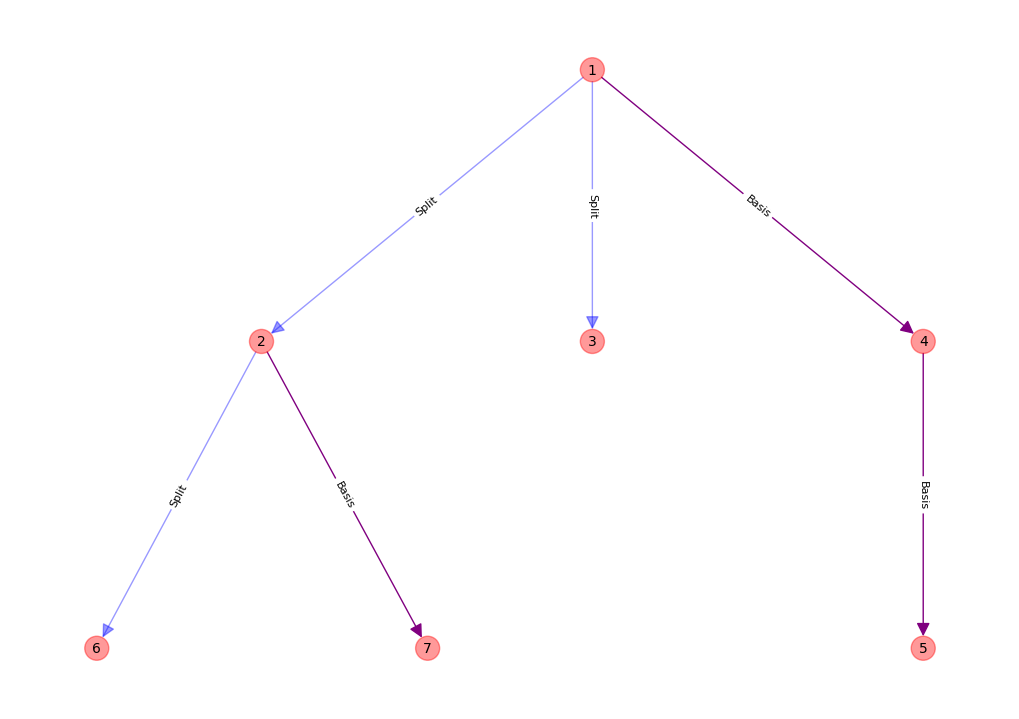

In [3]:
G = Lot._all[1].to_digraph()
graph_summary(G)

## Detail graph
This detail graph starts with Lot #7 and illustrates where it came from.

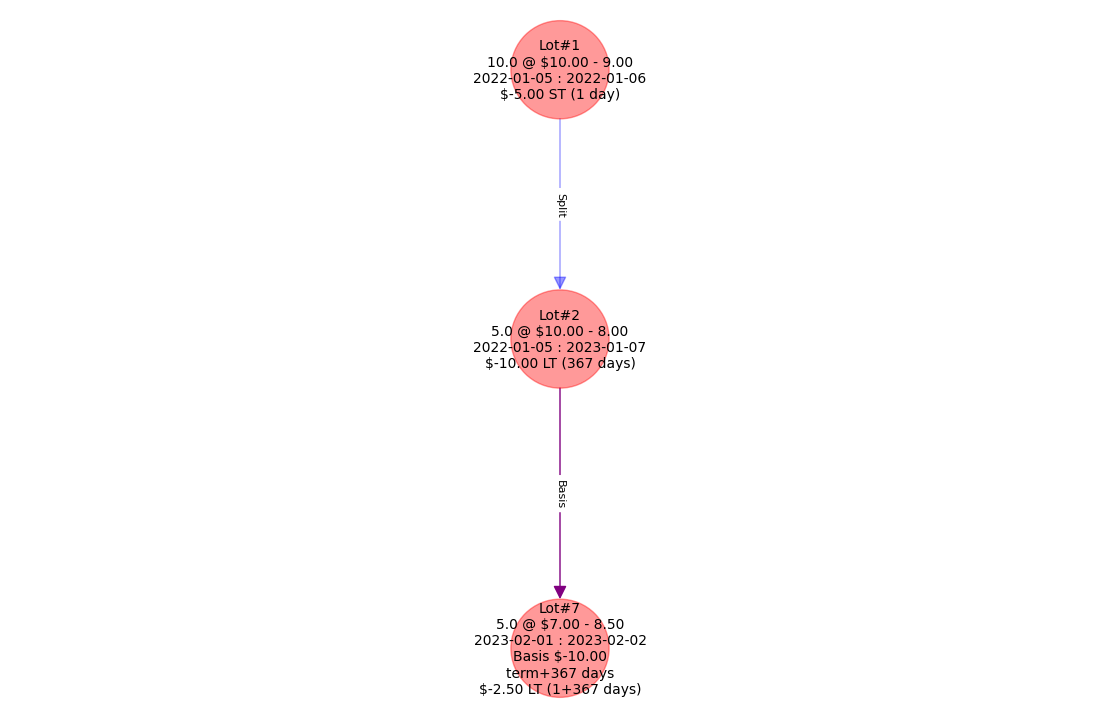

In [4]:
G = Lot._all[7].reverse_digraph()
graph_detail(G)

# Complex Example

In [5]:
from tax_tracker import PNLtracker, TaxLotSelection, Config
price_data = pd.read_csv(r'tests/PriceData.csv',
            index_col=[0, 1], parse_dates=[1]).sort_index()
distribution_data = pd.read_csv(r'tests/DistributionData.csv',
            index_col=[0, 1, 2], parse_dates=[1]).sort_index()
Config.tax_lot_selection = TaxLotSelection.LIFO
Lot.reset_class_variables()

In [6]:
tracker = PNLtracker(price_data, distribution_data)
start_date = pd.Timestamp('2022-01-05')
tracker.trade_dollars(start_date, 'NEA', 1_000)
# Get the next 4 months of ex-dividend dates for RA
ex_dates = distribution_data.loc[pd.IndexSlice['RA',
        (start_date):(start_date+pd.DateOffset(months=3)), :]].index.get_level_values(1)
last_date = None
for date in ex_dates:
    # Buy the day before each ex-date, so we get the dividend
    buy_date = tracker.prior_trading_date(date)
    # Sell half of the current value of NEA to fund the RA purchase
    opened_lots, closed_lots = tracker.trade(buy_date, 'NEA', -(tracker.get_position('NEA') / 2.0))
    dollars_sold = tracker.get_price(buy_date, 'NEA') * sum(lot.shares for lot in closed_lots)
    # Buy RA with the proceeds from the NEA sale
    tracker.trade_dollars(buy_date, 'RA', dollars_sold)
    # Sell RA after 14 days and buy NEA with the proceeds
    last_date = tracker.next_trading_date(date + pd.Timedelta(days=14))
    closed_lots = tracker.close(last_date, 'RA')
    proceeds = tracker.get_price(last_date, 'RA') * sum(lot.shares for lot in closed_lots)
    tracker.trade_dollars(last_date, 'NEA', proceeds)
last_date = tracker.next_trading_date(last_date)
tracker.close(last_date, 'NEA')
tracker.EoD(last_date)
tracker.validate()
taxable_cashflows = tracker.taxable_cashflows_df
print('Summary cashflows for tax calculations:\n'
    + pd.DataFrame(taxable_cashflows.sum()).T.to_string(index=False, float_format="{:.2f}".format))
print('\nAll lots:\n' + tracker.closed_lots_str)

Summary cashflows for tax calculations:
 Regular  Exempt  ShortTerm  LongTerm
   12.96    9.64    -127.08     -1.87

All lots:
  1 NEA: 2022-01-05 32.9598 @ $15.17 >> 2022-01-14 -32.9598 @ $14.66 = $-16.81 ST (9 days) washed
  3 RA: 2022-01-14 22.0848 @ $21.83 >> 2022-02-02 -22.0848 @ $21.40 = $-9.50 ST (19 days) washed
  7 RA: 2022-01-14 0.0495 @ $21.83 >> 2022-02-02 -0.0495 @ $21.40 = $-0.02 ST (19 days)
  2 NEA: 2022-01-05 32.9598 @ $15.17 >> 2022-02-07 -32.9598 @ $14.04 = $-37.24 ST (33 days) washed
  4 NEA: 2022-02-02 0.2932 @ $14.12 >> 2022-02-07 -0.2932 @ $14.04 = $-0.50 ST (5+42 days) washed
  8 RA: 2022-02-07 20.9295 @ $21.14 >> 2022-02-23 -20.9295 @ $20.08 = $-31.18 ST (16+19 days) washed
 13 RA: 2022-02-07 1.1553 @ $21.14 >> 2022-02-23 -1.1553 @ $20.08 = $-1.72 ST (16+19 days)
  6 NEA: 2022-02-02 32.6666 @ $14.12 >> 2022-03-14 -32.6666 @ $13.22 = $-82.97 ST (40+42 days) washed
  5 NEA: 2022-02-02 0.1684 @ $14.12 >> 2022-03-14 -0.1684 @ $13.22 = $-0.15 ST (40 days) washed
 14

## Graph all trades in NEA

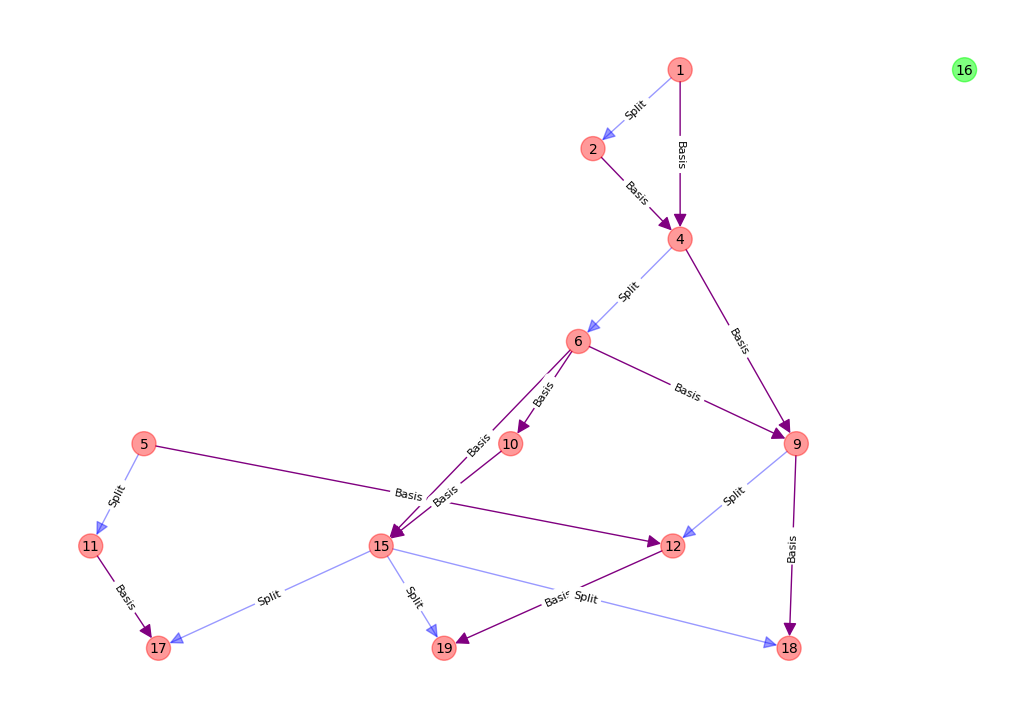

In [7]:
G = Lot._all[1].to_digraph()
for i, lot in Lot._all.items():
    if lot.lot_id > 1 and lot.ticker == 'NEA' and lot.split_from_id is None and not lot.basis_from_ids:
        G = nx.compose(G, lot.to_digraph())
graph_summary(G)

## Detail of one Lot
Let's show the details leading to Lot #18:

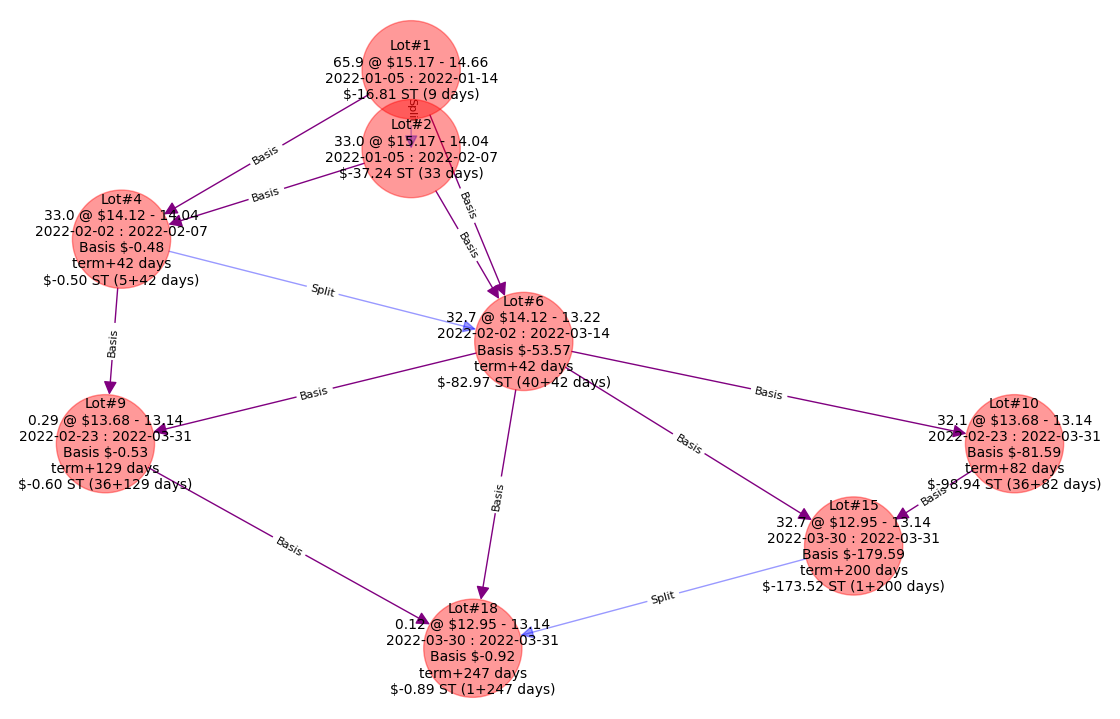

In [8]:
G = Lot._all[18].reverse_digraph()
graph_detail(G)